In [ ]:
# # Download the repository
# git clone https://github.com/cvg/GlueStick.git
# %cd GlueStick
# # Install requirements
# pip install -r requirements.txt
# wget https://github.com/cvg/GlueStick/releases/download/v0.1_arxiv/checkpoint_GlueStick_MD.tar -P resources/weights

Cloning into 'GlueStick'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 69 (delta 26), reused 37 (delta 9), pack-reused 0
Receiving objects: 100% (69/69), 33.04 MiB | 25.16 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/GlueStick


Download the pre-trained model

In [2]:
from os.path import join

import cv2
import torch
from matplotlib import pyplot as plt

from gluestick import batch_to_np, numpy_image_to_torch, GLUESTICK_ROOT
from gluestick.drawing import plot_images, plot_lines, plot_color_line_matches, plot_keypoints, plot_matches
from gluestick.models.two_view_pipeline import TwoViewPipeline

Define the configuration and model that we are going to use in our demo:

In [3]:
MAX_N_POINTS, MAX_N_LINES = 1000, 300

# Evaluation config
conf = {
    'name': 'two_view_pipeline',
    'use_lines': True,
    'extractor': {
        'name': 'wireframe',
        'sp_params': {
            'force_num_keypoints': False,
            'max_num_keypoints': MAX_N_POINTS,
        },
        'wireframe_params': {
            'merge_points': True,
            'merge_line_endpoints': True,
        },
        'max_n_lines': MAX_N_LINES,
    },
    'matcher': {
        'name': 'gluestick',
        'weights': str(GLUESTICK_ROOT / 'resources' / 'weights' / 'checkpoint_GlueStick_MD.tar'),
        'trainable': False,
    },
    'ground_truth': {
        'from_pose_depth': False,
    }
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline_model = TwoViewPipeline(conf).to(device).eval()
# pipeline_model

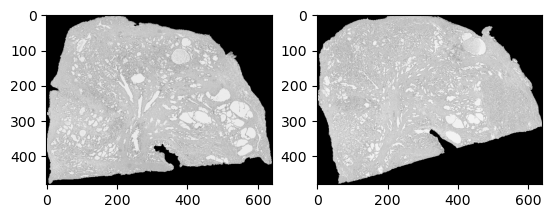

In [4]:
img_path0 = "/home/yoonk/Desktop/test/images/E05_resize_10.png"
img_path1 = "/home/yoonk/Desktop/test/images/E07_resize_10.png"

img = cv2.imread(img_path0, cv2.IMREAD_GRAYSCALE)

gray0 = cv2.imread(img_path0, 0)
gray1 = cv2.imread(img_path1, 0)

gray0 = cv2.resize(gray0, (640, 480))
gray1 = cv2.resize(gray1, (640, 480))

# Plot them using matplotlib
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gray0, cmap='gray')
axarr[1].imshow(gray1, cmap='gray')

In [5]:
# Convert images into torch and execute GlueStick💥

torch_gray0, torch_gray1 = numpy_image_to_torch(gray0), numpy_image_to_torch(gray1)
torch_gray0, torch_gray1 = torch_gray0.to(device)[None], torch_gray1.to(device)[None]
x = {'image0': torch_gray0, 'image1': torch_gray1}
pred = pipeline_model(x)

print(f"Detected Keypoints: {pred['keypoints0'].shape[1]} img1, {pred['keypoints1'].shape[1]} img2")
print(f"Detected Lines: {pred['lines0'].shape[1]} img1, {pred['lines1'].shape[1]} img2\n")
print(f"Matched {(pred['matches0'] >= 0).sum()} points and {(pred['line_matches0'] >= 0).sum()} lines")

Detected Keypoints: 1007 img1, 1006 img2
Detected Lines: 11 img1, 6 img2

Matched 18 points and 1 lines


Show some matches

In [6]:
pred = batch_to_np(pred)
kp0, kp1 = pred["keypoints0"], pred["keypoints1"]
m0 = pred["matches0"]

line_seg0, line_seg1 = pred["lines0"], pred["lines1"]
line_matches = pred["line_matches0"]

valid_matches = m0 != -1
match_indices = m0[valid_matches]
matched_kps0 = kp0[valid_matches]
matched_kps1 = kp1[match_indices]

valid_matches = line_matches != -1
match_indices = line_matches[valid_matches]
matched_lines0 = line_seg0[valid_matches]
matched_lines1 = line_seg1[match_indices]

## Detected Points

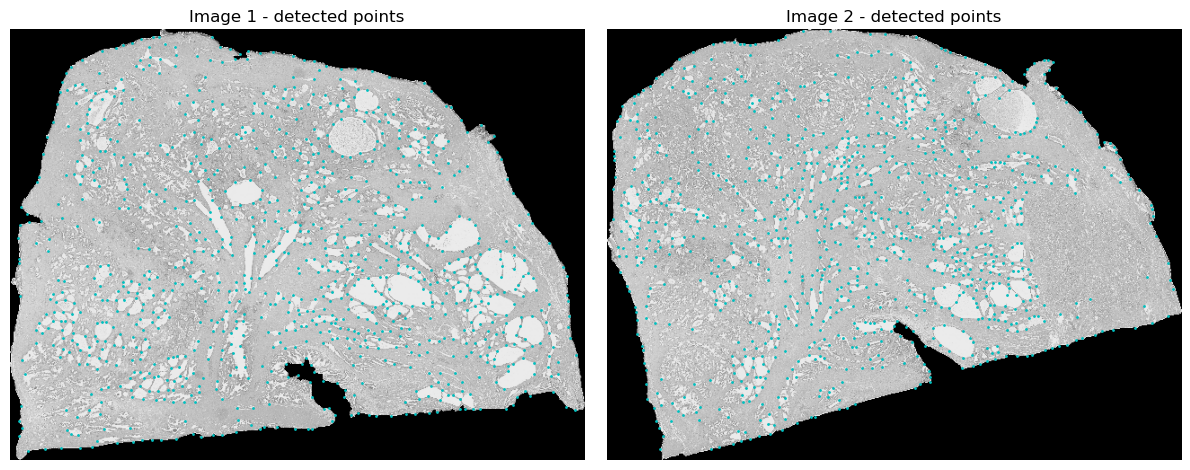

In [8]:
plot_images([img0, img1], ['Image 1 - detected points', 'Image 2 - detected points'], pad=0.5)
plot_keypoints([kp0, kp1], colors='c')

## Matched Points

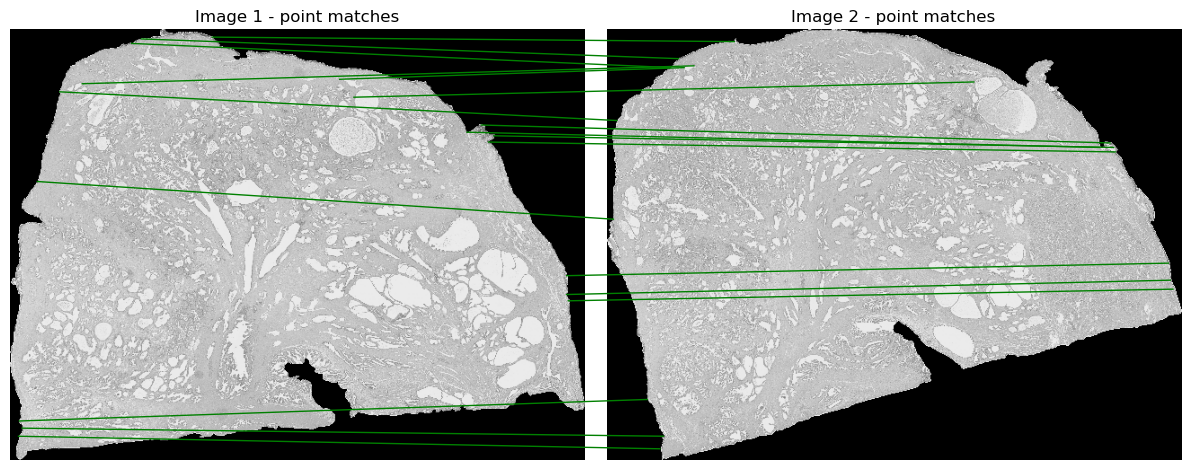

In [10]:
plot_images([img0, img1], ['Image 1 - point matches', 'Image 2 - point matches'], pad=0.5)
plot_matches(matched_kps0, matched_kps1, 'green', lw=1, ps=0)

# Homography estimation

If the scene is nearly a plane, we can estimate a robust homography using both, points and lines

In [11]:
# sudo apt-get update
# sudo apt-get install -y libceres-dev libeigen3-dev
# pip install git+https://github.com/rpautrat/homography_est.git@17b200d528e6aa8ac61a878a29265bf5f9d36c41

[sudo] password for yoonk: 
[sudo] password for yoonk: 

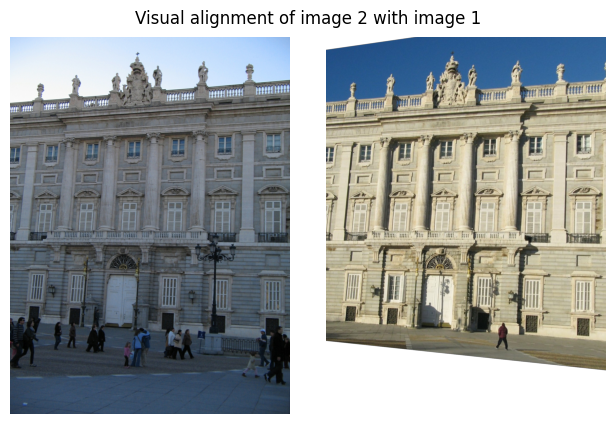

In [ ]:
import homography_est as hest

line_seg0 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines0.reshape(-1, 2, 2)]
line_seg1 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines1.reshape(-1, 2, 2)]

tol_px = 1.0
H = hest.ransac_point_line_homography(matched_kps0, matched_kps1, line_seg0, line_seg1, tol_px, False, [], [])

color0 = cv2.cvtColor(cv2.imread(img_path0), cv2.COLOR_BGR2RGBA)
color1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGBA)

warped = cv2.warpPerspective(color1, H, color0.shape[:2][::-1])

plot_images([color0, warped], pad=2.6)
plt.suptitle('Visual alignment of image 2 with image 1')
plt.show()

We can check how well aligned are both images generating a nice transition GIF 😎

In [20]:
#@title GIF Generation
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
from IPython.display import Video

n_frames = 10
# create samples distribution with different `std` values
frames_indices = np.append(np.arange(n_frames), np.arange(n_frames)[::-1])
pbar = tqdm(frames_indices, desc ="Generating animation", total=len(frames_indices)-1)
# func which will be applied in order to create a video frame
def func(i):
    plt.gca().clear()
    alpha = i / (n_frames - 1)
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(color0, alpha, warped, beta, 0.0)
    plt.gca().imshow(dst)
    plt.axis('off')

fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# create the animation using custom func and its parameters (fargs)
ani = animation.FuncAnimation(fig, func, pbar, interval=100,
                              repeat_delay=250, blit=False)

# save the animation into a specific video format
dst_file = './animation_homography.mp4'
ani.save(dst_file)
plt.close()

# custom html attributes set when lauching the video
Video(dst_file, embed=True, html_attributes="muted loop autoplay")

Generating animation:   0%|          | 0/19 [00:00<?, ?it/s]